# Scope of the Notebook

1. **Download the breast tumor image dataset from a public web source.**
   - Use a well-known dataset such as BreakHis or Breast Histopathology Images.
   - Organize the data into train/test splits.

2. **Develop a CNN-Transformer hybrid model.**
   - Implement the model architecture using PyTorch or TensorFlow.
   - Combine convolutional layers for feature extraction and transformer blocks for global context.

3. **Train the model on the training dataset.**
   - Set up data loaders, loss function, optimizer, and training loop.
   - Monitor training and validation accuracy.

4. **Test the model on the test dataset.**
   - Evaluate accuracy, precision, recall, and F1-score.

5. **Plot the confusion matrix for test predictions.**
   - Visualize model performance across classes.

6. **Summarize findings and discuss potential improvements.**

# 1. Data Loading and Exploration
First, we'll import the necessary libraries and load our dataset from the local directory.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

## Dataset Overview

The image dataset for this study contains three classes: **malignant**, **normal**, and **benign**. Each image is accompanied by a corresponding mask that highlights the tumor region. For this classification task, we will only use the images, not the masks.

In [4]:
dataset_path = r"Dataset_BUSI_with_GT"
classes = ['malignant', 'normal', 'benign']

images = []
labels = []

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    for fname in os.listdir(cls_path):
        if 'mask' not in fname:
            img_path = os.path.join(cls_path, fname)
            images.append(img_path) # Store file paths instead of loading images
            labels.append(i) # Use numerical labels
            
print(f"Found {len(images)} images belonging to {len(classes)} classes.")

Found 780 images belonging to 3 classes.


#### Show Dataset examples

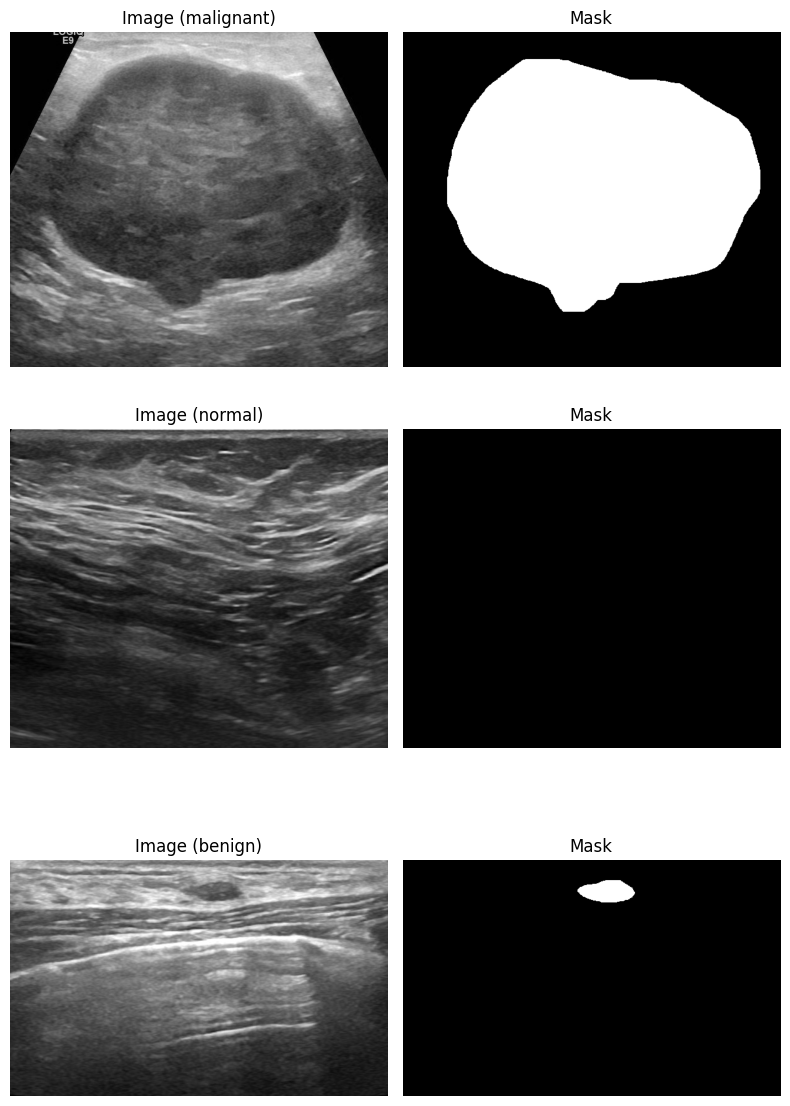

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i in range(3):
    # Find a random image for each class
    class_indices = [j for j, label in enumerate(labels) if label == i]
    random_index = random.choice(class_indices)
    
    img_path = images[random_index]
    mask_path = img_path.replace('.png', '_mask.png')
    
    axes[i, 0].imshow(Image.open(img_path), cmap='gray')
    axes[i, 0].set_title(f"Image ({classes[labels[random_index]]})")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Image.open(mask_path), cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

# 2. Data Preparation

Now we'll split our data, define transformations for data augmentation, and create PyTorch `Dataset` and `DataLoader` classes to feed the data to our model efficiently.

In [6]:
# Split data into training, validation, and testing sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 546
Validation samples: 117
Test samples: 117


In [7]:
# Define transformations
# Images are grayscale, but pre-trained models expect 3 channels. We'll duplicate the channel.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Duplicate channels
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L') # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Datasets and DataLoaders
train_dataset = BreastCancerDataset(X_train, y_train, transform=data_transforms['train'])
val_dataset = BreastCancerDataset(X_val, y_val, transform=data_transforms['val'])
test_dataset = BreastCancerDataset(X_test, y_test, transform=data_transforms['val']) # Use val transform for test

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. CNN-Transformer Hybrid Model

Here's the core of the project. We'll create a hybrid model that uses a pre-trained CNN (ResNet-50) as a feature extractor. The output of the CNN is then flattened into a sequence of patches and fed into a Transformer Encoder, which learns the global relationships between features. Finally, a classification head produces the output.

In [8]:
class CNNViTHybrid(nn.Module):
    def __init__(self, num_classes, cnn_backbone='resnet50', embed_dim=256, nhead=8, num_layers=6):
        super(CNNViTHybrid, self).__init__()
        
        # CNN Backbone (Feature Extractor)
        if cnn_backbone == 'resnet50':
            cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.feature_extractor = nn.Sequential(*list(cnn.children())[:-2])
            cnn_output_channels = 2048 # ResNet50's last conv block channels
        else:
            raise ValueError("Unsupported CNN backbone")
            
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 50, embed_dim)) # 7x7 feature map + 1 cls token
        
        # Projection layer to match Transformer's embedding dimension
        self.projection = nn.Conv2d(cnn_output_channels, embed_dim, kernel_size=1)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification Head
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # 1. Extract features with CNN
        x = self.feature_extractor(x) # Output shape: (batch, 2048, 7, 7)
        
        # 2. Project to Transformer's embedding dimension
        x = self.projection(x) # Output shape: (batch, 256, 7, 7)
        
        # 3. Flatten and prepare for Transformer
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1) # Shape: (batch, 49, 256)
        
        # 4. Add CLS token
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # Shape: (batch, 50, 256)
        
        # 5. Add positional encoding
        x += self.pos_encoder
        
        # 6. Pass through Transformer Encoder
        x = self.transformer_encoder(x) # Shape: (batch, 50, 256)
        
        # 7. Use the output of the CLS token for classification
        cls_output = x[:, 0]
        output = self.classifier(cls_output)
        
        return output

# Setup device, model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNViTHybrid(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Diego/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 80.1MB/s]


Using device: cuda


# 4. Model Training

We'll train the model for a set number of epochs, validating its performance after each epoch. The model with the best validation accuracy will be saved.

In [9]:
num_epochs = 20
best_val_acc = 0.0
best_model_path = 'best_hybrid_model.pth'

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    train_corrects = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        
    train_loss = running_loss / len(train_dataset)
    train_acc = train_corrects.double() / len(train_dataset)
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            
    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")

Epoch 1/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


Epoch 1/20 -> Train Loss: 1.0272 Acc: 0.5348 | Val Loss: 0.6472 Acc: 0.7436
New best model saved with validation accuracy: 0.7436


Epoch 2/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.83it/s]


Epoch 2/20 -> Train Loss: 0.7155 Acc: 0.6960 | Val Loss: 0.9373 Acc: 0.7094


Epoch 3/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


Epoch 3/20 -> Train Loss: 0.5351 Acc: 0.7875 | Val Loss: 0.6476 Acc: 0.7778
New best model saved with validation accuracy: 0.7778


Epoch 4/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


Epoch 4/20 -> Train Loss: 0.4748 Acc: 0.8425 | Val Loss: 0.4530 Acc: 0.8291
New best model saved with validation accuracy: 0.8291


Epoch 5/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


Epoch 5/20 -> Train Loss: 0.3854 Acc: 0.8645 | Val Loss: 0.5539 Acc: 0.8205


Epoch 6/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


Epoch 6/20 -> Train Loss: 0.3456 Acc: 0.8755 | Val Loss: 0.4205 Acc: 0.8205


Epoch 7/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]


Epoch 7/20 -> Train Loss: 0.2878 Acc: 0.8938 | Val Loss: 0.6425 Acc: 0.8291


Epoch 8/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]


Epoch 8/20 -> Train Loss: 0.2883 Acc: 0.9121 | Val Loss: 0.4624 Acc: 0.8547
New best model saved with validation accuracy: 0.8547


Epoch 9/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Epoch 9/20 -> Train Loss: 0.1795 Acc: 0.9377 | Val Loss: 0.4247 Acc: 0.8632
New best model saved with validation accuracy: 0.8632


Epoch 10/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]


Epoch 10/20 -> Train Loss: 0.2082 Acc: 0.9414 | Val Loss: 0.6408 Acc: 0.7949


Epoch 11/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Epoch 11/20 -> Train Loss: 0.2565 Acc: 0.9249 | Val Loss: 0.6249 Acc: 0.7778


Epoch 12/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]


Epoch 12/20 -> Train Loss: 0.1874 Acc: 0.9487 | Val Loss: 0.6491 Acc: 0.8462


Epoch 13/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 13/20 -> Train Loss: 0.2632 Acc: 0.9139 | Val Loss: 0.7944 Acc: 0.7778


Epoch 14/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch 14/20 -> Train Loss: 0.2250 Acc: 0.9396 | Val Loss: 0.4819 Acc: 0.8120


Epoch 15/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 15/20 -> Train Loss: 0.2673 Acc: 0.8938 | Val Loss: 0.6857 Acc: 0.8205


Epoch 16/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


Epoch 16/20 -> Train Loss: 0.4017 Acc: 0.8553 | Val Loss: 0.7675 Acc: 0.7778


Epoch 17/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]


Epoch 17/20 -> Train Loss: 0.2696 Acc: 0.9121 | Val Loss: 0.5380 Acc: 0.8291


Epoch 18/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Epoch 18/20 -> Train Loss: 0.2113 Acc: 0.9341 | Val Loss: 0.4755 Acc: 0.8547


Epoch 19/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 19/20 -> Train Loss: 0.1761 Acc: 0.9414 | Val Loss: 0.4593 Acc: 0.8632


Epoch 20/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

Epoch 20/20 -> Train Loss: 0.1493 Acc: 0.9469 | Val Loss: 0.7827 Acc: 0.8376


# 5. Model Evaluation

Finally, we load our best-performing model and evaluate it on the unseen test set. We'll generate a classification report with key metrics and visualize the performance with a confusion matrix.

Testing: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Classification Report:
              precision    recall  f1-score   support

   malignant       0.80      0.62      0.70        32
      normal       0.70      0.70      0.70        20
      benign       0.81      0.89      0.85        65

    accuracy                           0.79       117
   macro avg       0.77      0.74      0.75       117
weighted avg       0.79      0.79      0.78       117



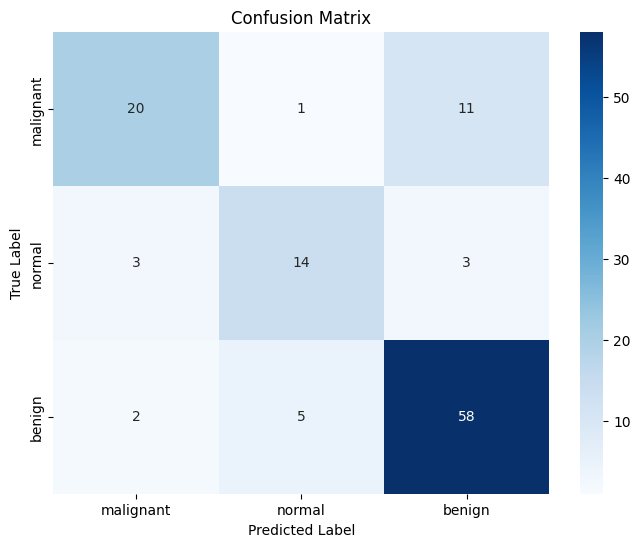

In [10]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Showcase: Test Set Predictions

In this section, we demonstrate the hybrid CNN-Transformer model's predictions on a few randomly selected images from the test set. For each image, we display:

- The input ultrasound image.
- The true class label.
- The predicted class label from the model.

This helps visualize how well the model generalizes to unseen data and provides qualitative insight into its performance.

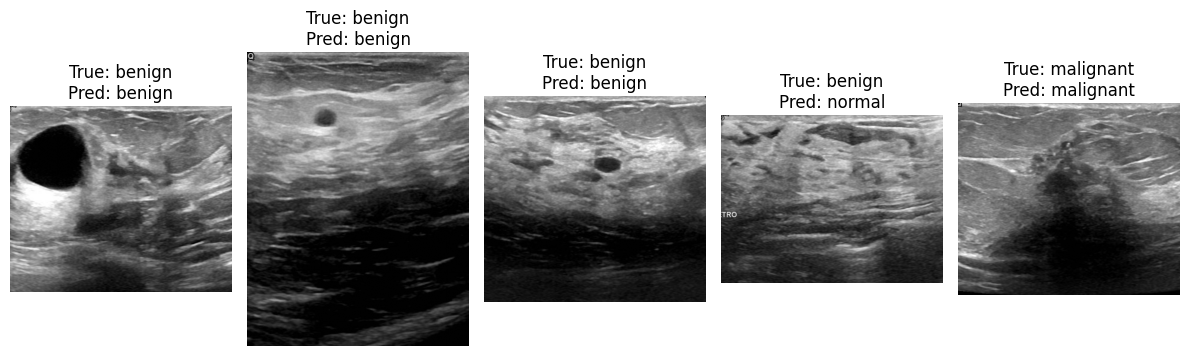

In [11]:
# Visualize 5 random test set predictions

num_show = 5
indices = random.sample(range(len(X_test)), num_show)

plt.figure(figsize=(12, 10))
for i, idx in enumerate(indices):
    img_path = X_test[idx]
    img = Image.open(img_path).convert('L')
    true_label = classes[y_test[idx]]
    pred_label = classes[all_preds[idx]]

    plt.subplot(1, num_show, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 6. Summary and Findings

This notebook successfully implemented a hybrid CNN-Transformer model for breast tumor classification. 

**Key Steps:**
1. Loaded and preprocessed the BUSI dataset.
2. Split the data into training, validation, and test sets.
3. Implemented a hybrid architecture using a pre-trained ResNet-50 backbone and a Transformer Encoder.
4. Trained the model, saving the best version based on validation accuracy.
5. Evaluated the model on the test set, generating a classification report and a confusion matrix.

**Potential Improvements:**
* **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, optimizer settings, and Transformer configurations (e.g., number of heads, layers).
* **Different CNN Backbones:** Try other pre-trained models like EfficientNet or DenseNet to see if they provide better feature extraction.
* **More Data/Augmentation:** A larger dataset or more aggressive data augmentation could further improve generalization.
* **Longer Training:** Training for more epochs might yield better results, provided overfitting is managed (e.g., with early stopping).